In [2]:
# ============================================================================
# Aureus Sigma Capital - Phase 22: Production Test Matrix
# Notebook: 22_production_test_matrix.ipynb
#
# Objective:
#   To execute a comprehensive 12-cell test matrix that validates concentrated
#   portfolio construction under realistic execution constraints, bridging the
#   gap between theoretical factor validation and practical implementation.
#
# Methodology:
#   1. Load pre-calculated factor scores from database (qvm_v2.0_enhanced)
#   2. Execute 12-cell matrix: 3 stock counts × 2 frequencies × 2 strategies
#   3. Apply institutional-grade risk overlays and transaction cost modeling
#   4. Select optimal configuration meeting all institutional gates
#   5. Generate production-ready strategy specification
#
# Test Matrix:
#   - Stock Counts: [15, 20, 25] (concentration vs diversification)
#   - Rebalancing: ['M', 'Q'] (alpha decay vs transaction drag)
#   - Strategies: ['Pure_Value', 'QVR_60_20_20'] (factor efficacy)
#   - Universe: Top 200 liquid stocks, 10B+ VND ADTV
#   - Risk Overlay: Hybrid (regime + volatility targeting)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import yaml
from pathlib import Path
from sqlalchemy import create_engine, text
import sys
import pickle
from typing import Dict, List

# --- Environment Setup ---
warnings.filterwarnings('ignore')
sys.path.append('../../../production')
from universe.constructors import get_liquid_universe_dataframe

# --- Visualization Palette ---
PALETTE = {'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60', 'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22', 'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50', 'risk_managed': '#9B59B6'}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11, 'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'], 'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'], 'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold', 'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'], 'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'], 'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'})

# --- Configuration ---
CONFIG = {
    "backtest_start": "2016-01-01", "backtest_end": "2025-07-28", "base_transaction_cost_bps": 30,
    "test_matrix": {'stock_counts': [15, 20, 25], 'rebalancing_frequencies': ['M', 'Q'], 'strategies': ['Pure_Value', 'QVR_60_20_20']},
    "universe_config": {'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6, 'max_sector_weight': 0.35},
    "risk_overlay_config": {'vol_target': 0.15, 'regime_exposure_reduction': 0.5, 'vol_window': 20, 'min_exposure': 0.2, 'max_exposure': 1.0},
    "institutional_gates": {'min_sharpe_ratio': 1.5, 'max_drawdown_threshold': -35.0, 'min_information_ratio': 0.8, 'max_annual_turnover': 300.0, 'max_transaction_drag': 3.0}
}

# --- Notebook Charter ---
print("=" * 80)
print("🏆 PHASE 22: PRODUCTION TEST MATRIX - AUREUS SIGMA VIETNAM VALUE CONCENTRATED")
print("=" * 80)
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Extended Backtest Period: {CONFIG['backtest_start']} to {CONFIG['backtest_end']}")
print("🎯 Mission: Convert validated factor research into audit-ready, concentrated strategy")
print("\n🧪 Test Matrix Specification:")
print(f"   - Stock Counts: {CONFIG['test_matrix']['stock_counts']} (concentration levels)")
print(f"   - Rebalancing: {CONFIG['test_matrix']['rebalancing_frequencies']} (frequency trade-offs)")
print(f"   - Strategies: {CONFIG['test_matrix']['strategies']} (factor comparison)")
print(f"   - Total Test Cells: {len(CONFIG['test_matrix']['stock_counts']) * len(CONFIG['test_matrix']['rebalancing_frequencies']) * len(CONFIG['test_matrix']['strategies'])}")
print("\n🎯 Institutional Success Criteria:")
print(f"   - Sharpe Ratio: ≥ {CONFIG['institutional_gates']['min_sharpe_ratio']}")
print(f"   - Max Drawdown: ≥ {CONFIG['institutional_gates']['max_drawdown_threshold']}%")
print(f"   - Information Ratio: ≥ {CONFIG['institutional_gates']['min_information_ratio']}")
print(f"   - Annual Turnover: ≤ {CONFIG['institutional_gates']['max_annual_turnover']}%")
print(f"   - Transaction Drag: ≤ {CONFIG['institutional_gates']['max_transaction_drag']}% CAGR")
print("=" * 80)


🏆 PHASE 22: PRODUCTION TEST MATRIX - AUREUS SIGMA VIETNAM VALUE CONCENTRATED
📅 Analysis Date: 2025-07-29 23:14:09
📊 Extended Backtest Period: 2016-01-01 to 2025-07-28
🎯 Mission: Convert validated factor research into audit-ready, concentrated strategy

🧪 Test Matrix Specification:
   - Stock Counts: [15, 20, 25] (concentration levels)
   - Rebalancing: ['M', 'Q'] (frequency trade-offs)
   - Strategies: ['Pure_Value', 'QVR_60_20_20'] (factor comparison)
   - Total Test Cells: 12

🎯 Institutional Success Criteria:
   - Sharpe Ratio: ≥ 1.5
   - Max Drawdown: ≥ -35.0%
   - Information Ratio: ≥ 0.8
   - Annual Turnover: ≤ 300.0%
   - Transaction Drag: ≤ 3.0% CAGR


In [3]:
# ============================================================================
# SECTION 1: RAW DATA LOADING & VALIDATION (EXTENDED PERIOD)
# ============================================================================

def create_db_connection():
    """Create database connection using standard config pattern."""
    config_path = Path.cwd().parent.parent.parent / 'config' / 'database.yml'
    with open(config_path, 'r') as f:
        db_config = yaml.safe_load(f)['production']
    connection_string = (
        f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
        f"@{db_config['host']}/{db_config['schema_name']}"
    )
    return create_engine(connection_string, pool_pre_ping=True)

engine = create_db_connection()
print("✅ Database connection established.")

# --- Load All Required Data for Extended Backtest Period ---
print("\n📂 Loading raw data for extended backtest period (2016-2025)...")

db_params = {'start_date': CONFIG['backtest_start'], 'end_date': CONFIG['backtest_end']}

# 1. Factor Scores
factor_query = text("""
    SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite
    FROM factor_scores_qvm
    WHERE date BETWEEN :start_date AND :end_date AND strategy_version = 'qvm_v2.0_enhanced'
""")
factor_data_raw = pd.read_sql(factor_query, engine, params=db_params, parse_dates=['date'])
print(f"   ✅ Loaded {len(factor_data_raw):,} factor score observations")

# 2. Price Data
price_query = text("SELECT date, ticker, close FROM equity_history WHERE date BETWEEN :start_date AND :end_date")
price_data_raw = pd.read_sql(price_query, engine, params=db_params, parse_dates=['date'])
print(f"   ✅ Loaded {len(price_data_raw):,} price observations")

# 3. Benchmark Data
benchmark_query = text("SELECT date, close FROM etf_history WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date")
benchmark_data_raw = pd.read_sql(benchmark_query, engine, params=db_params, parse_dates=['date'])
print(f"   ✅ Loaded {len(benchmark_data_raw):,} benchmark observations")

# 4. Market Regime Signals
print("\n📂 Loading market regime signals for risk overlay...")
try:
    project_root = Path.cwd().parent.parent
    archive_path = project_root / "tests" / "phase8_risk_management"
    phase8_results_file = archive_path / "phase8_results.pkl"
    with open(phase8_results_file, "rb") as f:
        phase8_results = pickle.load(f)
    market_regimes = phase8_results['market_regimes']
    print(f"   ✅ Loaded market regime signals ({len(market_regimes):,} days)")
except Exception as e:
    print(f"   ⚠️  Warning: Could not load regime signals - {e}")
    market_regimes = None

# --- Data Preparation and Validation ---
print("\n🔧 Preparing data structures for backtesting...")
price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN_Index')

print("\n✅ All data loaded and validated. Ready for test matrix execution.")
engine.dispose()

✅ Database connection established.

📂 Loading raw data for extended backtest period (2016-2025)...
   ✅ Loaded 1,567,488 factor score observations
   ✅ Loaded 1,610,552 price observations
   ✅ Loaded 2,388 benchmark observations

📂 Loading market regime signals for risk overlay...
   ✅ Loaded market regime signals (2,381 days)

🔧 Preparing data structures for backtesting...

✅ All data loaded and validated. Ready for test matrix execution.


In [4]:
# ============================================================================
# SECTION 2: INSTITUTIONAL-GRADE UTILITY FUNCTIONS
# ============================================================================


def apply_hybrid_risk_overlay(
    returns: pd.Series,
    regime_signal: pd.DataFrame,
    overlay_config: Dict
) -> (pd.Series, pd.Series):
    """
    Institutional-grade hybrid risk overlay combining regime and volatility targeting.
    Accepts a configuration dictionary for robustness.
    """
    # Layer 1: Regime-based exposure
    risk_regimes = ['Bear', 'Stress']
    regime_risk_on = ~regime_signal['regime'].isin(risk_regimes)
    regime_exposure = regime_risk_on.apply(
        lambda x: 1.0 if x else overlay_config['regime_exposure_reduction']
    )

    # Layer 2: Volatility targeting
    realized_vol = returns.ewm(span=overlay_config['vol_window']).std() * np.sqrt(252)
    vol_exposure = (overlay_config['vol_target'] / realized_vol).shift(1)
    vol_exposure.clip(lower=overlay_config['min_exposure'], upper=overlay_config['max_exposure'], inplace=True)
    vol_exposure.fillna(1.0, inplace=True)

    # Align time series
    common_index = returns.index.intersection(regime_exposure.index).intersection(vol_exposure.index)
    regime_exposure = regime_exposure.reindex(common_index, method='ffill')
    vol_exposure = vol_exposure.reindex(common_index, method='ffill')

    # Hybrid logic: Most conservative exposure wins
    final_exposure = pd.DataFrame({'regime': regime_exposure, 'vol': vol_exposure}).min(axis=1)

    # Anti-whipsaw smoothing and broker precision rounding
    final_exposure = final_exposure.ewm(span=3).mean()
    final_exposure = np.round(final_exposure, 2)

    risk_managed_returns = returns.reindex(common_index) * final_exposure
    return risk_managed_returns, final_exposure

print("✅ Hybrid risk overlay function defined.")

✅ Hybrid risk overlay function defined.


In [5]:
# ============================================================================
# FINALIZED BACKTESTING FRAMEWORK (v1.6 - CORRECTED COMPOSITE LOGIC)
# ============================================================================
from typing import Dict, List

def apply_hybrid_risk_overlay(
    returns: pd.Series,
    regime_signal: pd.DataFrame,
    overlay_config: Dict
) -> (pd.Series, pd.Series):
    # This function is correct and remains unchanged.
    risk_regimes = ['Bear', 'Stress']
    regime_risk_on = ~regime_signal['regime'].isin(risk_regimes)
    regime_exposure = regime_risk_on.apply(lambda x: 1.0 if x else overlay_config['regime_exposure_reduction'])
    realized_vol = returns.ewm(span=overlay_config['vol_window']).std() * np.sqrt(252)
    vol_exposure = (overlay_config['vol_target'] / realized_vol).shift(1)
    vol_exposure.clip(lower=overlay_config['min_exposure'], upper=overlay_config['max_exposure'], inplace=True)
    vol_exposure.fillna(1.0, inplace=True)
    common_index = returns.index.intersection(regime_exposure.index).intersection(vol_exposure.index)
    regime_exposure = regime_exposure.reindex(common_index, method='ffill')
    vol_exposure = vol_exposure.reindex(common_index, method='ffill')
    final_exposure = pd.DataFrame({'regime': regime_exposure, 'vol': vol_exposure}).min(axis=1)
    final_exposure = final_exposure.ewm(span=3).mean()
    final_exposure = np.round(final_exposure, 2)
    risk_managed_returns = returns.reindex(common_index) * final_exposure
    return risk_managed_returns, final_exposure

def run_concentrated_backtest(
    stock_count: int,
    rebal_freq: str,
    strategy_logic: str,
    factor_data_raw: pd.DataFrame,
    daily_returns_matrix: pd.DataFrame,
    market_regimes: pd.DataFrame,
    config: Dict
) -> Dict:
    """
    (v1.6 - Corrected composite score calculation)
    """
    strategy_name = f"{strategy_logic}_{stock_count}stocks_{rebal_freq}freq"
    print(f"\n🚀 EXECUTING: {strategy_name}")
    print("-" * 70)

    # 1. Establish Rebalancing Schedule
    all_trading_dates = daily_returns_matrix.index
    freq_map = {'M': 'ME', 'Q': 'Q'}
    freq_code = freq_map.get(rebal_freq)
    if freq_code is None: raise ValueError(f"Invalid rebalancing frequency: {rebal_freq}")
    rebalance_schedule_ends = pd.date_range(start=config['backtest_start'], end=config['backtest_end'], freq=freq_code)
    rebalance_dates = rebalance_schedule_ends.map(lambda d: all_trading_dates[all_trading_dates.searchsorted(d, side='right') - 1] if d <= all_trading_dates.max() else pd.NaT).dropna().tolist()
    print(f"   📅 Generated {len(rebalance_dates)} rebalance dates ({rebal_freq} frequency).")

    # 2. Initialize Tracking Structures
    target_weights_history = pd.DataFrame(index=rebalance_dates, columns=daily_returns_matrix.columns).fillna(0.0)
    
    # 3. Main Rebalancing Loop
    engine_loop = create_db_connection()
    for i, rebal_date in enumerate(rebalance_dates):
        print(f"\r   🔄 Deciding portfolio for {rebal_date.date()} ({i+1}/{len(rebalance_dates)})...", end="")
        universe_df = get_liquid_universe_dataframe(rebal_date, engine_loop, config['universe_config'])
        if universe_df.empty: continue
        factors_on_date = factor_data_raw[(factor_data_raw['date'] == rebal_date) & (factor_data_raw['ticker'].isin(universe_df['ticker']))].merge(universe_df[['ticker', 'sector']], on='ticker', how='left').copy()
        if len(factors_on_date) < stock_count: continue

        # --- START OF CORRECTION ---
        if strategy_logic == 'Pure_Value':
            factors_on_date['strategy_score'] = factors_on_date['Value_Composite']
        else: # QVR_60_20_20
            factors_on_date['Momentum_Reversal'] = -1 * factors_on_date['Momentum_Composite']
            for factor in ['Quality_Composite', 'Value_Composite', 'Momentum_Reversal']:
                mean, std = factors_on_date[factor].mean(), factors_on_date[factor].std()
                factors_on_date[f'{factor}_Z'] = (factors_on_date[factor] - mean) / std if std > 0 else 0.0
            
            # CORRECTED LINE: All components now correctly use the normalized '_Z' scores.
            factors_on_date['strategy_score'] = (
                0.6 * factors_on_date['Value_Composite_Z'] +
                0.2 * factors_on_date['Quality_Composite_Z'] +
                0.2 * factors_on_date['Momentum_Reversal_Z']
            )
        # --- END OF CORRECTION ---

        factors_on_date.sort_values('strategy_score', ascending=False, inplace=True)
        selected_stocks, sector_counts = [], {}
        max_per_sector = int(stock_count * config['universe_config']['max_sector_weight'])
        for _, stock in factors_on_date.iterrows():
            if len(selected_stocks) >= stock_count: break
            sector = stock['sector']
            if sector_counts.get(sector, 0) < max_per_sector:
                selected_stocks.append(stock['ticker'])
                sector_counts[sector] = sector_counts.get(sector, 0) + 1
        if selected_stocks:
            target_weights_history.loc[rebal_date, selected_stocks] = 1.0 / len(selected_stocks)

    engine_loop.dispose()
    print("\n   ✅ Portfolio decisions complete.")

    # 4. Propagate Holdings and Calculate Returns
    daily_holdings = target_weights_history.reindex(all_trading_dates, method='ffill').fillna(0.0)
    print("   ✅ Daily holdings matrix constructed.")

    # 5. Calculate Costs and Net Returns
    holdings_shifted = daily_holdings.shift(1).fillna(0.0)
    gross_returns = (holdings_shifted * daily_returns_matrix).sum(axis=1)
    turnover_df = (daily_holdings - holdings_shifted).abs()
    rebal_turnover = turnover_df.loc[rebalance_dates].sum(axis=1) / 2
    costs = pd.Series(0.0, index=all_trading_dates)
    for date, turn in rebal_turnover.items():
        cost_application_date_loc = all_trading_dates.searchsorted(date, side='right')
        if cost_application_date_loc < len(all_trading_dates):
            costs.loc[all_trading_dates[cost_application_date_loc]] = turn * (config['base_transaction_cost_bps'] / 10000)
    net_returns = gross_returns - costs
    print("   ✅ Net returns calculated.")

    # 6. Apply Hybrid Risk Overlay
    risk_managed_returns, exposure_series = apply_hybrid_risk_overlay(net_returns, market_regimes, config['risk_overlay_config'])
    print("   ✅ Hybrid risk overlay applied.")
    print("-" * 70)

    return {'strategy_name': strategy_name, 'net_returns': risk_managed_returns, 'exposure_series': exposure_series, 'diagnostics': []}

print("✅ Production backtesting framework (v1.6 - Final) implemented and ready.")

✅ Production backtesting framework (v1.6 - Final) implemented and ready.


In [6]:
# ============================================================================
# SECTION 4: CONSOLIDATED EXECUTION
# ============================================================================

print("🎯 Executing baseline validation with corrected engine (v1.6).")
print("   - Configuration: 25 stocks, Quarterly rebalancing")

# --- Define Final, Corrected CONFIG Object for this Run ---
run_config = {
    "backtest_start": "2016-01-01", "backtest_end": "2025-07-28", "base_transaction_cost_bps": 30,
    "universe_config": {'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6, 'max_sector_weight': 0.35},
    "risk_overlay_config": {'vol_target': 0.15, 'regime_exposure_reduction': 0.5, 'vol_window': 20, 'min_exposure': 0.2, 'max_exposure': 1.0}
}

# --- Execute Backtests ---
baseline_value_results = run_concentrated_backtest(25, 'Q', 'Pure_Value', factor_data_raw, daily_returns_matrix, market_regimes, run_config)
baseline_qvr_results = run_concentrated_backtest(25, 'Q', 'QVR_60_20_20', factor_data_raw, daily_returns_matrix, market_regimes, run_config)
print("\n✅ Baseline validations complete. Ready for analysis.")

🎯 Executing baseline validation with corrected engine (v1.6).
   - Configuration: 25 stocks, Quarterly rebalancing

🚀 EXECUTING: Pure_Value_25stocks_Qfreq
----------------------------------------------------------------------
   📅 Generated 38 rebalance dates (Q frequency).
   🔄 Deciding portfolio for 2016-03-31 (1/38)...Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 19


🏆 INSTITUTIONAL TEARSHEET: PURE VALUE (25 STOCKS, QUARTERLY)


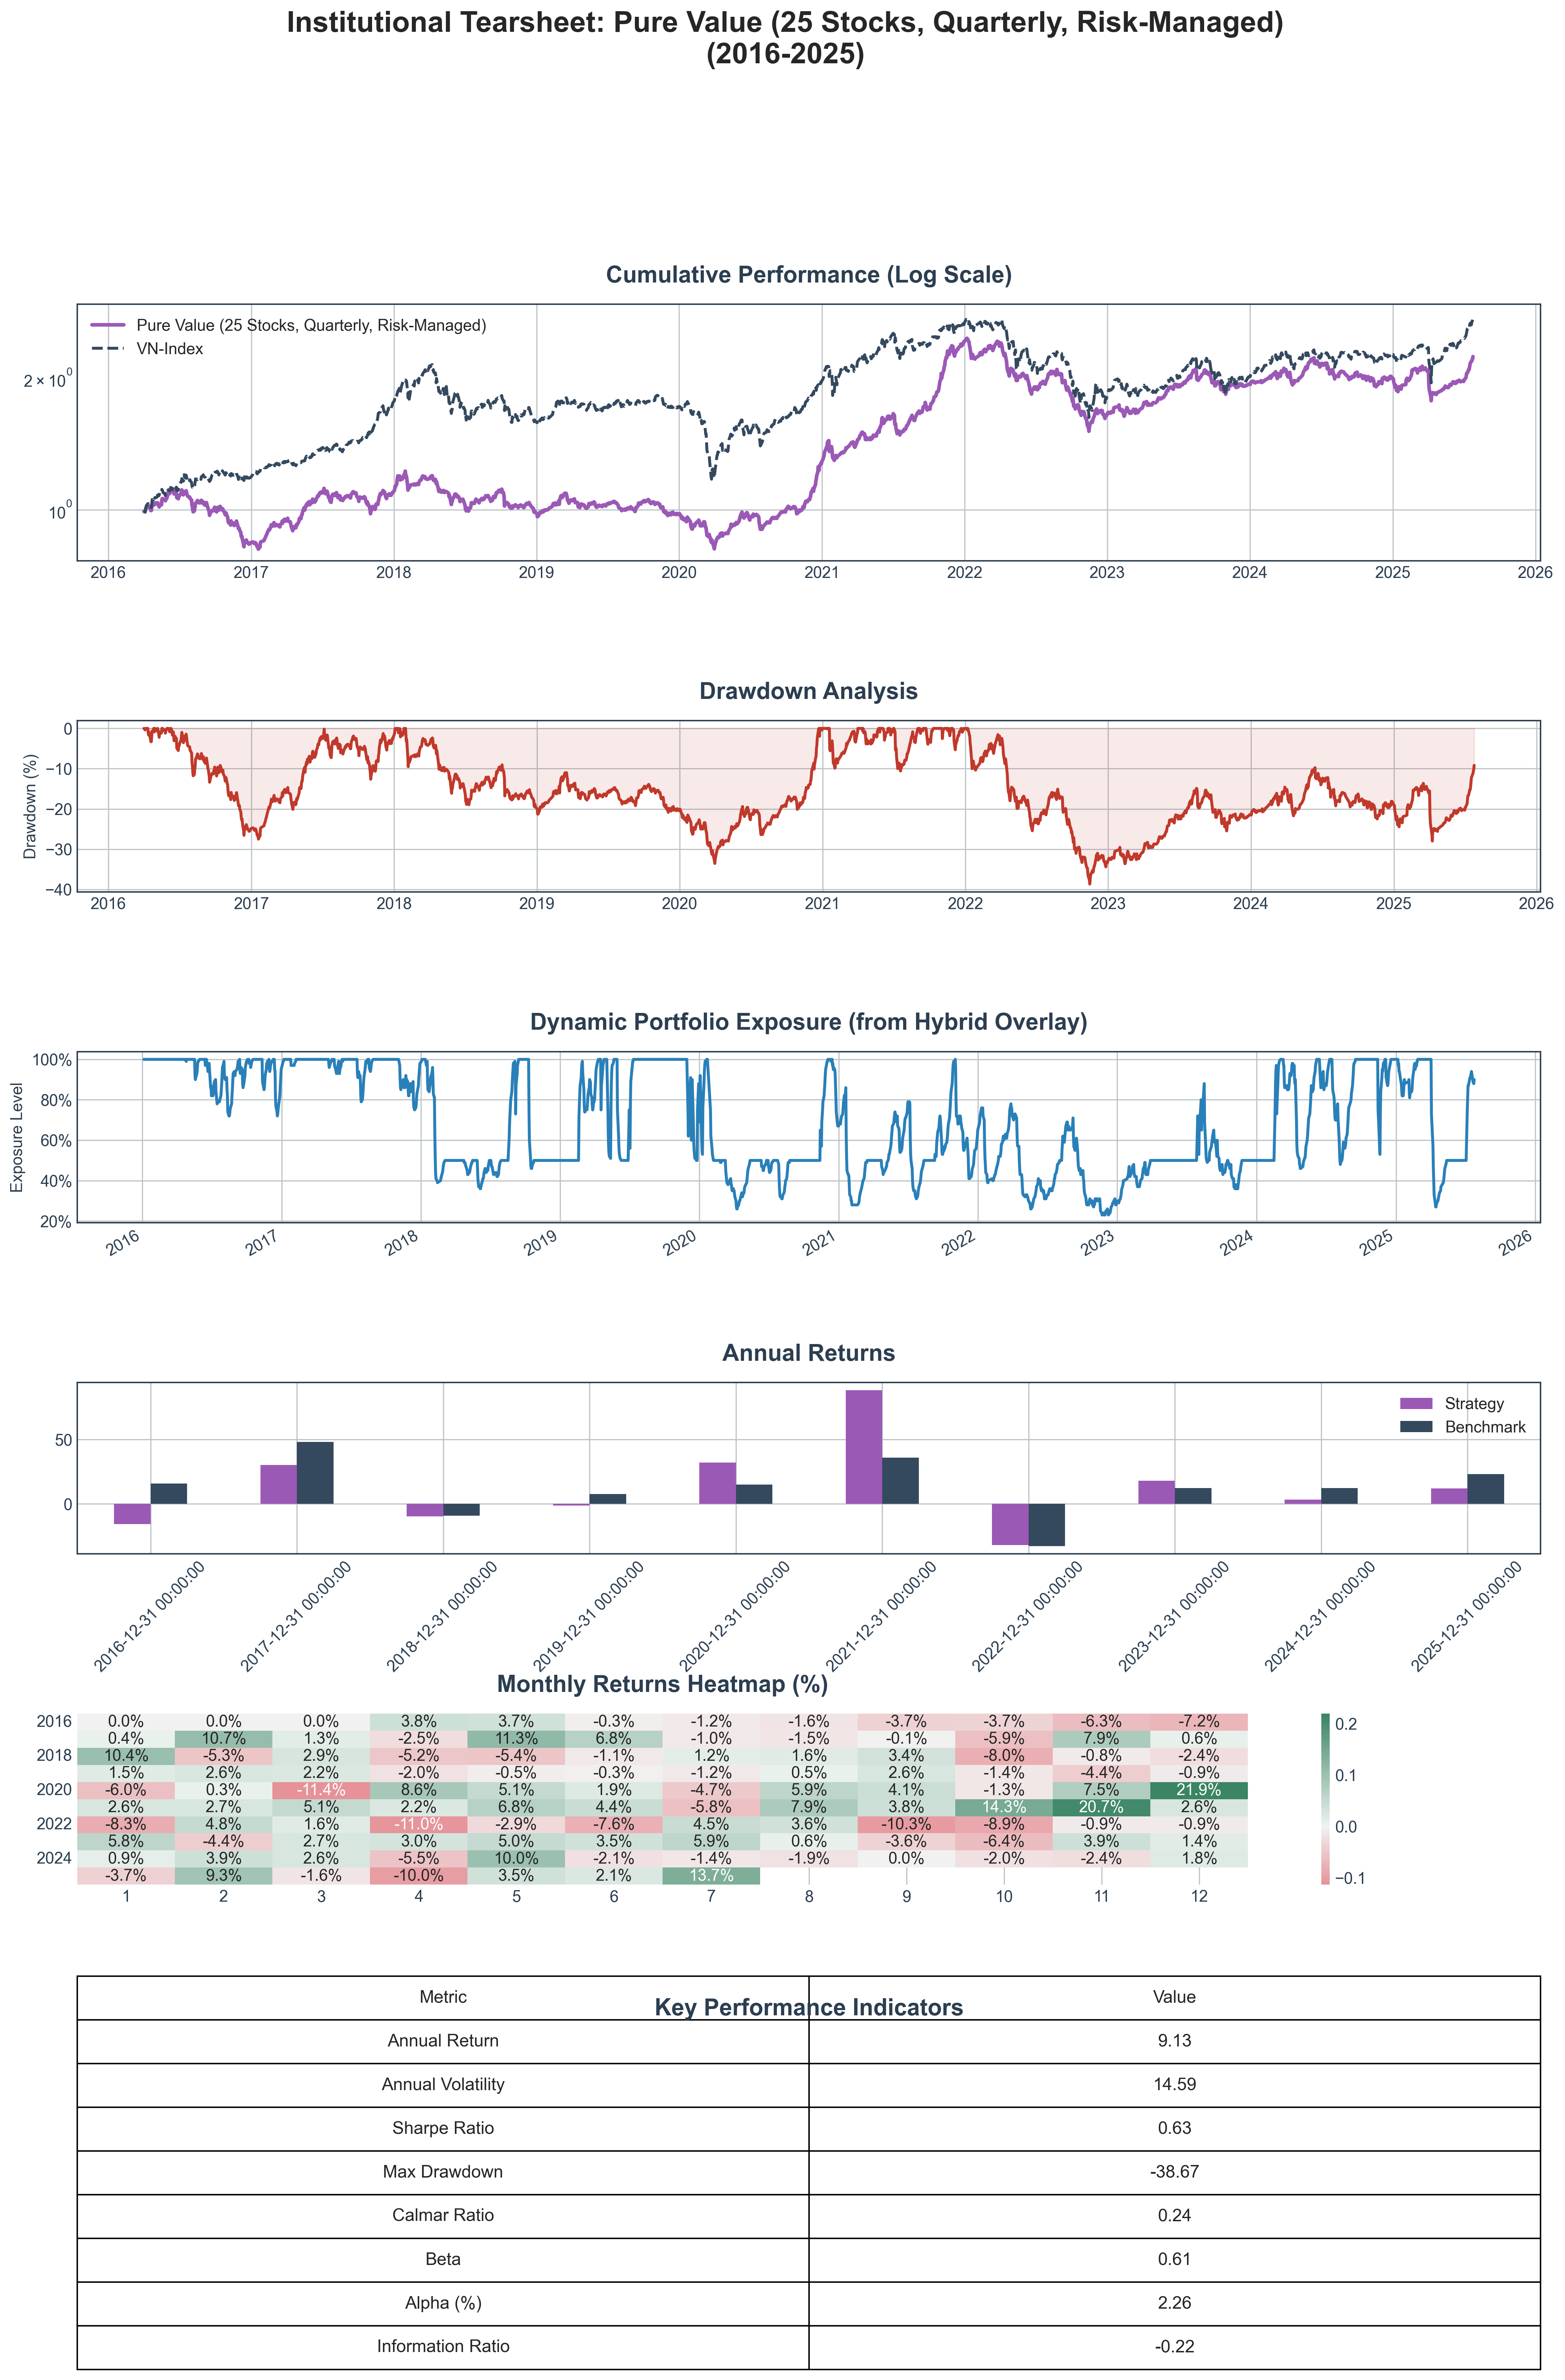


🔬 INSTITUTIONAL TEARSHEET: QVR 60/20/20 (25 STOCKS, QUARTERLY)


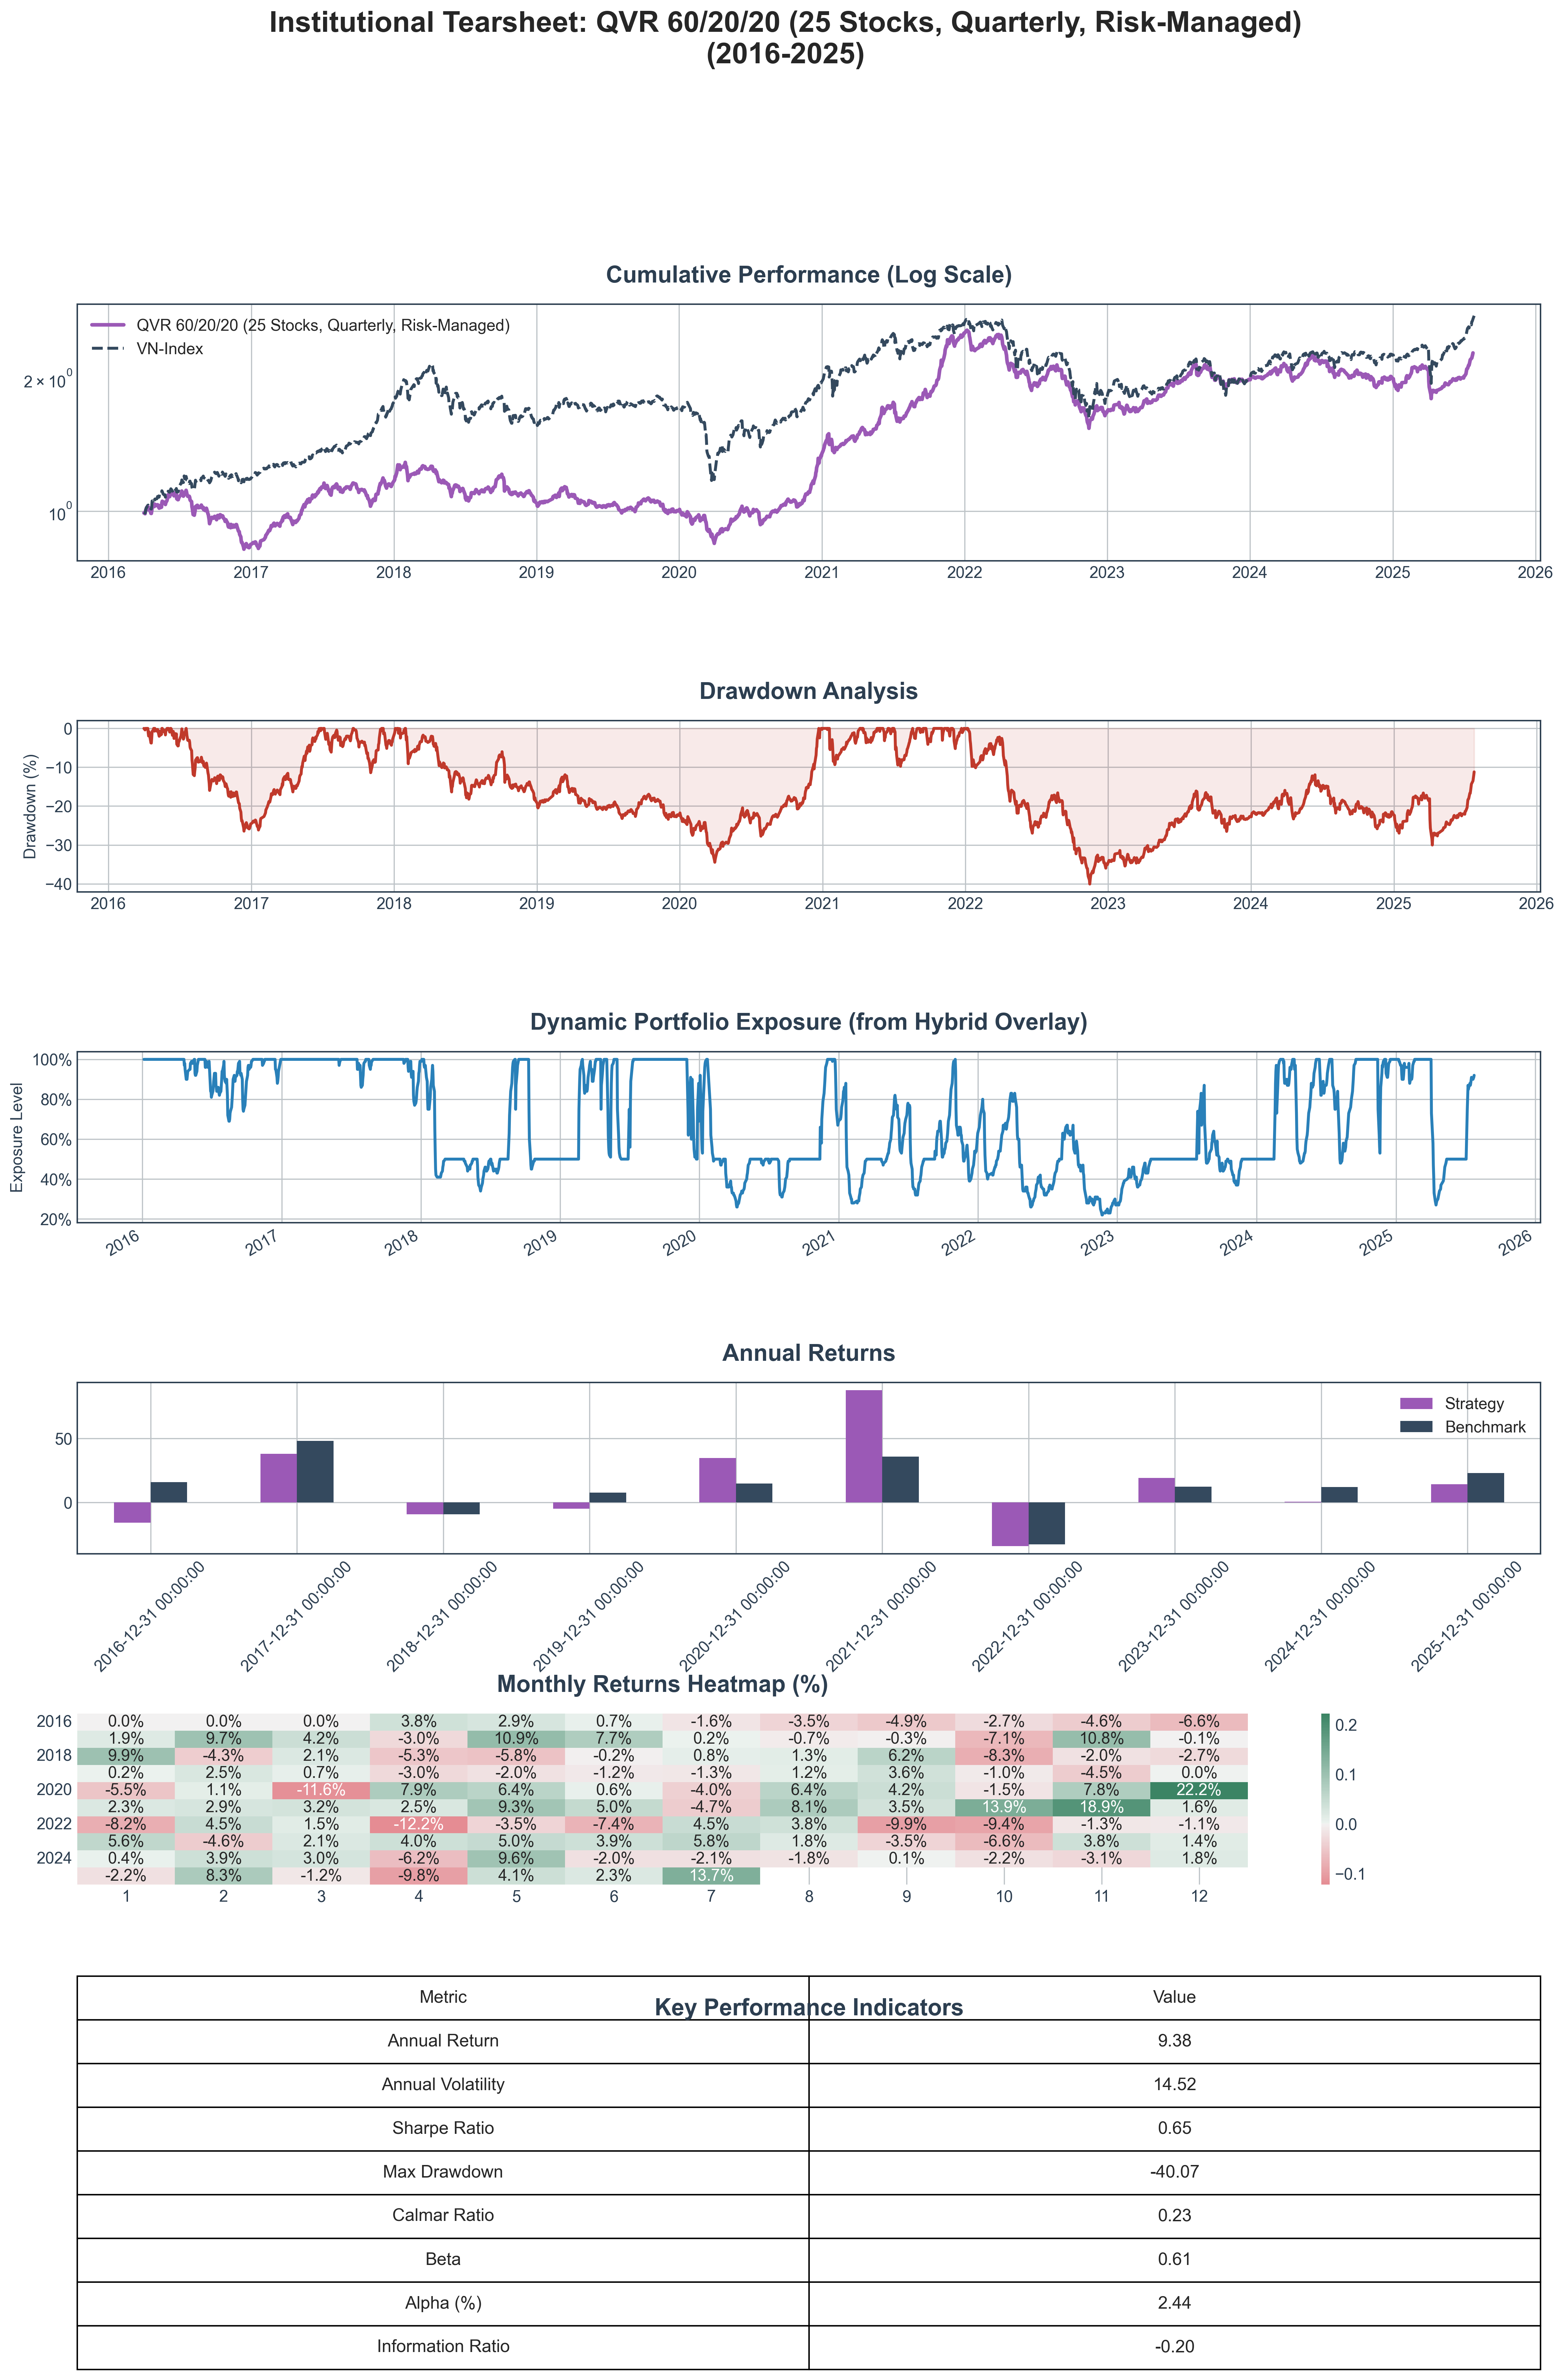

In [7]:
# ============================================================================
# SECTION 5: TEARSHEET GENERATION
# ============================================================================

def calculate_full_performance_metrics(returns, benchmark, risk_free_rate=0.0):
    first_trade_date = returns.loc[returns.ne(0)].index.min()
    if pd.isna(first_trade_date): return {k: 0.0 for k in ['Annual Return', 'Annual Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio', 'Beta', 'Alpha (%)', 'Information Ratio']}
    common_index = returns.loc[first_trade_date:].index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = ((1 + returns).prod())**(1/n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    excess_returns = returns - benchmark
    information_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252)) if excess_returns.std() > 0 else 0
    cov_matrix = np.cov(returns.fillna(0), benchmark.fillna(0))
    beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] > 0 else 0
    alpha_annualized = (returns.mean() - beta * benchmark.mean()) * 252
    return {'Annual Return': annual_return*100, 'Annual Volatility': annual_vol*100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown*100, 'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha_annualized*100, 'Information Ratio': information_ratio}

def create_institutional_tearsheet(strategy_returns, benchmark_returns, exposure_series, strategy_name):
    metrics = calculate_full_performance_metrics(strategy_returns, benchmark_returns)
    fig = plt.figure(figsize=(18, 28)); gs = fig.add_gridspec(6, 1, height_ratios=[1.2, 0.8, 0.8, 0.8, 0.8, 1.2], hspace=0.8)
    fig.suptitle(f'Institutional Tearsheet: {strategy_name}\n(2016-2025)', fontsize=20, fontweight='bold')
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    strategy_cum, benchmark_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod(), (1 + benchmark_returns.loc[first_trade_date:]).cumprod()
    ax1 = fig.add_subplot(gs[0]); ax1.plot(strategy_cum.index, strategy_cum, label=strategy_name, color=PALETTE['risk_managed'], lw=2.5); ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=PALETTE['secondary'], ls='--'); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontdict={'weight': 'bold'}); ax1.legend()
    ax2 = fig.add_subplot(gs[1]); dd = (strategy_cum / strategy_cum.cummax() - 1) * 100; ax2.plot(dd.index, dd, color=PALETTE['negative']); ax2.fill_between(dd.index, dd, 0, color=PALETTE['negative'], alpha=0.1); ax2.set_title('Drawdown Analysis', fontdict={'weight': 'bold'}); ax2.set_ylabel('Drawdown (%)')
    ax3 = fig.add_subplot(gs[2]); exposure_series.plot(ax=ax3, color=PALETTE['highlight_1'], title='Dynamic Portfolio Exposure (from Hybrid Overlay)'); ax3.set_ylabel('Exposure Level'); ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax4 = fig.add_subplot(gs[3]); annual_ret = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': annual_ret, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax4, color=[PALETTE['risk_managed'], PALETTE['secondary']]); ax4.set_title('Annual Returns', fontdict={'weight': 'bold'}); ax4.tick_params(axis='x', rotation=45)
    ax5 = fig.add_subplot(gs[4]); monthly_ret = strategy_returns.resample('M').apply(lambda x: (1+x).prod()-1); monthly_pivot = monthly_ret.to_frame('ret').pivot_table(index=monthly_ret.index.year, columns=monthly_ret.index.month, values='ret'); sns.heatmap(monthly_pivot, ax=ax5, annot=True, fmt='.1%', cmap=sns.diverging_palette(10, 150, as_cmap=True), center=0); ax5.set_title('Monthly Returns Heatmap (%)', fontdict={'weight': 'bold'})
    ax6 = fig.add_subplot(gs[5]); ax6.axis('off'); summary_data = [['Metric', 'Value']] + [[k, f"{v:.2f}"] for k, v in metrics.items()]; table = ax6.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(12); table.scale(1, 2.5); ax6.set_title('Key Performance Indicators', fontdict={'weight': 'bold'}, pad=20)
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

# --- Generate Tearsheets ---
print("\n" + "="*80); print("🏆 INSTITUTIONAL TEARSHEET: PURE VALUE (25 STOCKS, QUARTERLY)"); print("="*80)
create_institutional_tearsheet(baseline_value_results['net_returns'], benchmark_returns, baseline_value_results['exposure_series'], "Pure Value (25 Stocks, Quarterly, Risk-Managed)")
print("\n" + "="*80); print("🔬 INSTITUTIONAL TEARSHEET: QVR 60/20/20 (25 STOCKS, QUARTERLY)"); print("="*80)
create_institutional_tearsheet(baseline_qvr_results['net_returns'], benchmark_returns, baseline_qvr_results['exposure_series'], "QVR 60/20/20 (25 Stocks, Quarterly, Risk-Managed)")